In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

from utils import (get_train_mnist,
                   get_test_mnist, 
                   train,
                   test)

from plot import plot_weight_distribution
from args import args, kwargs

### Для начала обучим обычную модель, на датасете MNIST
### Сделаем все необходимые для этого импорты и подготовим код для обучения модели

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, bias=False)
        self.conv2 = nn.Conv2d(8, 8, 3, stride=5, bias=False)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        return output

In [19]:
def train_and_eval(model, train_loader, test_loader):
    if args['cuda']:
        model.cuda()

    history = []
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    for epoch in range(1, args['epochs'] + 1):

        train(model, epoch, loss_fn, optimizer, train_loader)
        acc = test(model, loss_fn, optimizer, test_loader)
        history.append(acc)

    return acc

In [22]:
train_loader =  get_train_mnist()
test_loader= get_test_mnist()

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [117]:
model = SimpleCNN()
hist = train_and_eval(model, train_loader, test_loader)

## Квантизация

### Теперь мы хотим написать класс квантизатор, который будет квантизовать входящий тензор.
### Заметим что параметр S у нас будет обучамыем, но с другой стороны мы так же сможем его задать исходя из значений тензора.

In [29]:
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    def round_pass(self, x):
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5)
        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        x = x / (s_scale)
        x = torch.clamp(x, self.thd_neg, self.thd_pos)
        x = self.round_pass(x)
        x = x * (s_scale)

        return x

### Посмотрим на то как работает получившийся квантизатор

<Figure size 1000x700 with 0 Axes>

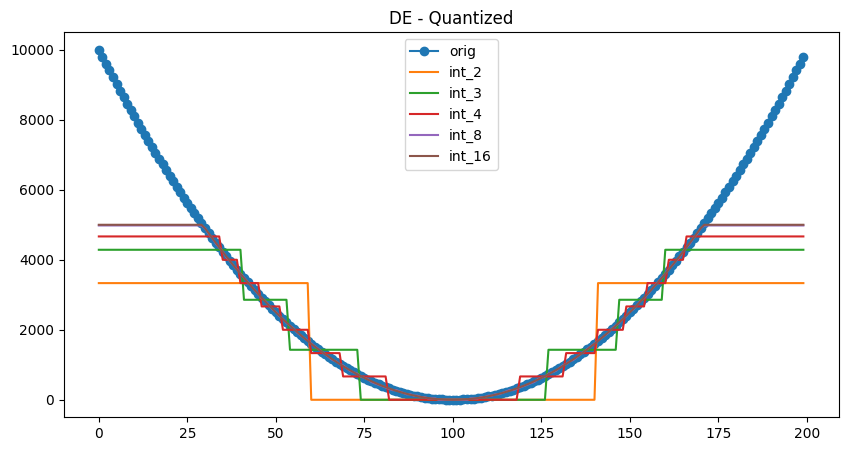

In [60]:
vector =(np.arange(-100, 100, 1))**2

vector = torch.tensor(vector)

plt.figure(figsize=(10,7))

f = plt.figure(figsize = (10, 5))

plt.plot(range(len(vector)), vector,label='orig', marker='o')
for bit in [2,3,4, 8, 16]:
    quantizer = Quantizer(bit)
    quantizer.init_from(vector)
    dequantized = quantizer(vector)

    dequantized = dequantized.detach().numpy()

    plt.plot(range(len(vector)),dequantized,label=f'int_{bit}')

plt.title('DE - Quantized');
plt.legend();

### Небольшая функция для отрисовки гистограмм весов модели

3


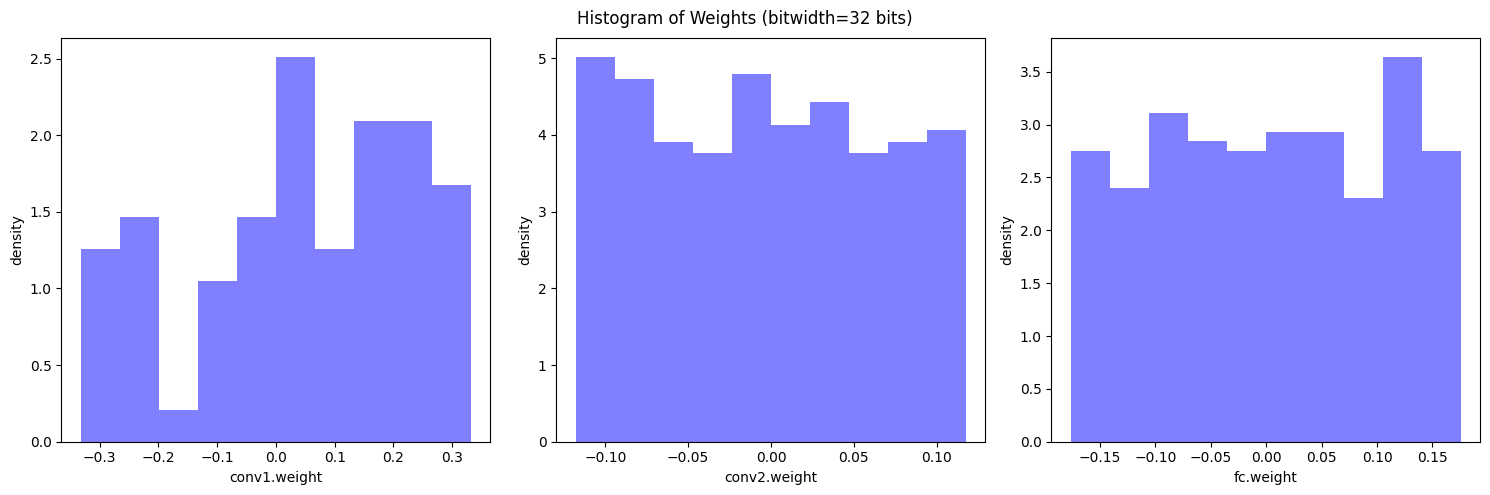

In [118]:
plot_weight_distribution(model,Quantizer, bitwidth=32)

3


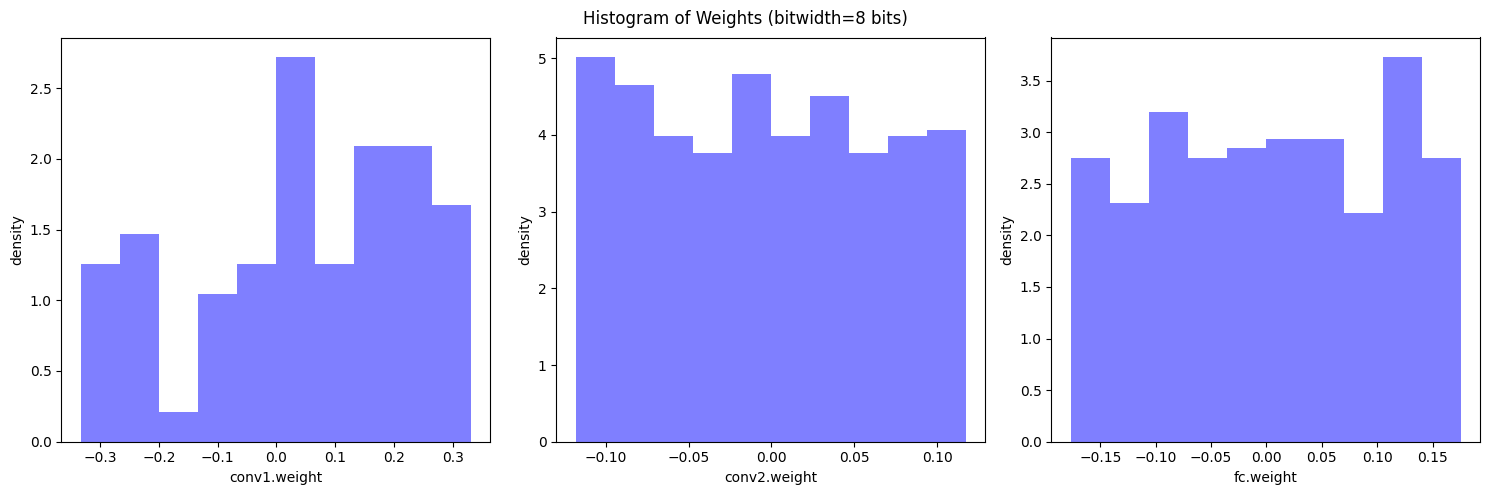

In [119]:
plot_weight_distribution(model,Quantizer,bitwidth=8)

3


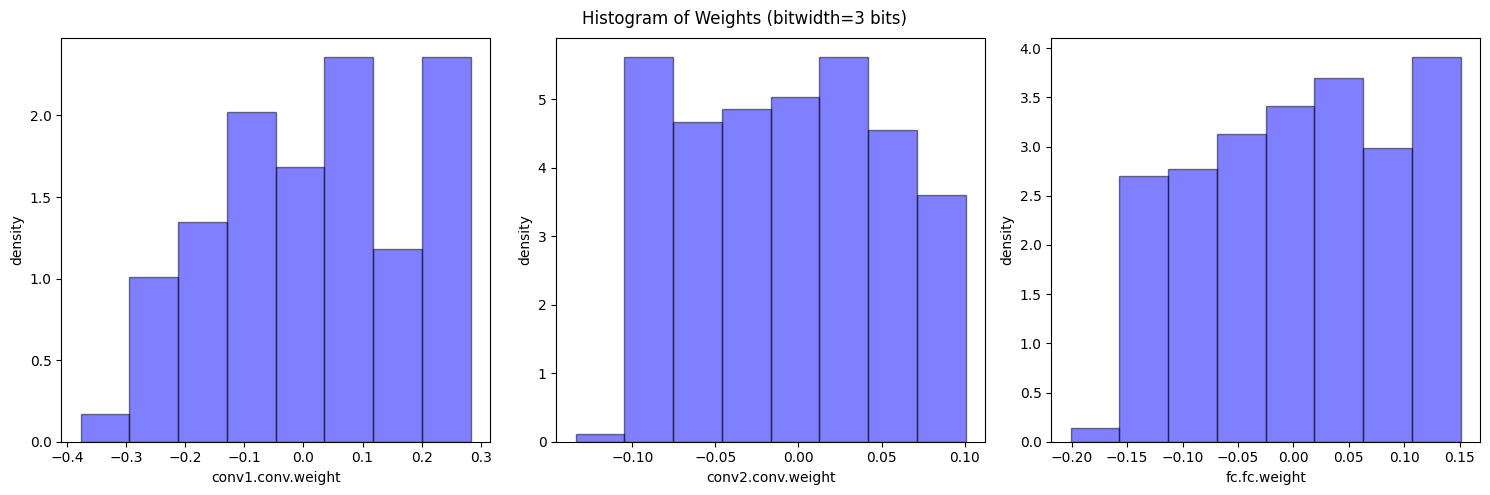

In [128]:
plot_weight_distribution(model,Quantizer,bitwidth=3)

### Теперь напишем функции сверточного и линейного слоев которые поддерживают квантизацию

In [65]:
class QAConv2d(nn.Module):
    def __init__(self, bit, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super(QAConv2d, self).__init__()
        self.bit = bit
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weight = Quantizer(bit)
        self.quantizer_weight.init_from(self.conv.weight)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weight(self.conv.weight).int()
        quantized_act = self.quantizer_act(input_x).int()
        out = nn.functional.conv2d(quantized_act, quantized_weight, None, self.stride, self.padding)
        return out

class QALinear(nn.Module):
    def __init__(self, bit, ch_in,ch_out):
        super(QALinear, self).__init__()
        self.bit = bit
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.fc = nn.Linear(ch_in, ch_out, bias=True)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_bias = self.quantizer_bias(self.fc.bias).int()
        quantized_weight = self.quantizer_weigh(self.fc.weight).int()
        quantized_act = self.quantizer_act(input_x).int()
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias)
        return out

### Объявим нашу модель с учетом этих слоев

In [70]:
class QuanSimpleCNN(nn.Module):
    def __init__(self, bit):
        super(QuanSimpleCNN, self).__init__()
        self.conv1 = QAConv2d(bit,1, 8, 3, stride=1)
        self.conv2 = QAConv2d(bit,8, 8, 3, stride=5)
        self.fc = QALinear(bit, 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        return output

In [71]:
model = QuanSimpleCNN(32)
hist = train_and_eval(model, train_loader, test_loader)

3


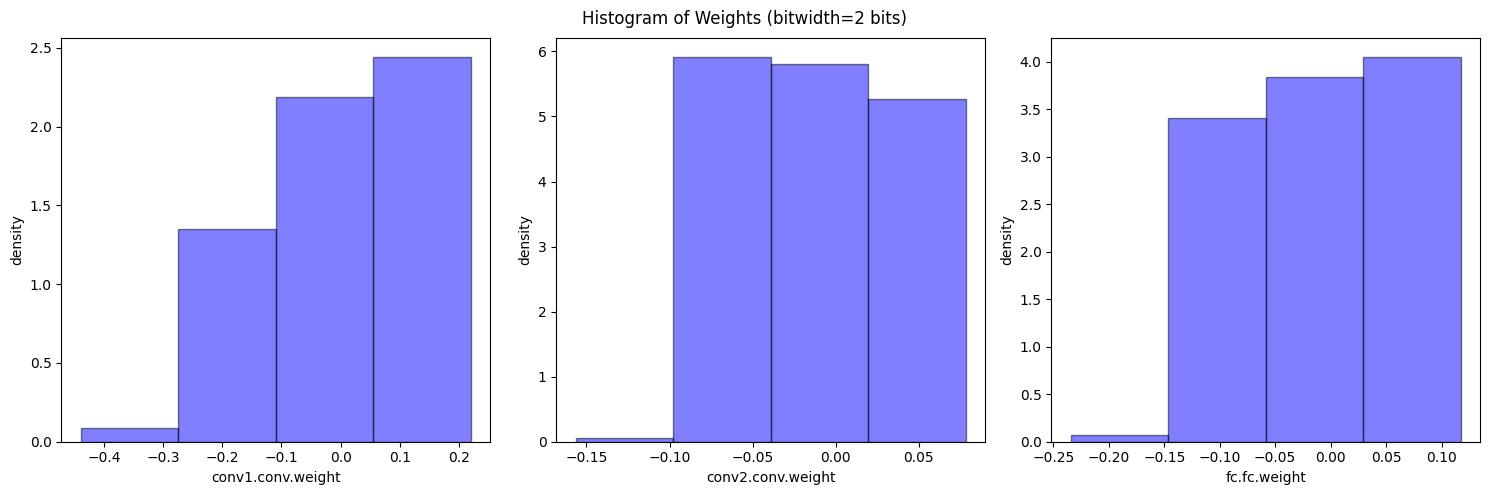

In [126]:
model = QuanSimpleCNN(2)
plot_weight_distribution(model,Quantizer, bitwidth=2)

In [129]:
hist = train_and_eval(model, train_loader, test_loader)

In [132]:
plot_weight_distribution(model,Quantizer, bitwidth=2)

In [ ]:
model = QuanSimpleCNN(2)
hist = train_and_eval(model, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306151
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.228784
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.996147
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.777641
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.568478
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.420762

Test set: Average loss: 0.0024, Accuracy: 5979/10000 (60%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.240245
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.134355
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.169941
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.235830
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.232019
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.124308

Test set: Average loss: 0.0022, Accuracy: 6290/10000 (63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.105709
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.039904
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.168751
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.110978
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.042305
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

In [133]:
plot_weight_distribution(model,Quantizer,bitwidth=2)